# Enron - POI Detector using Machine Learning

In the year 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

## Overview of the Project

In this project we use machine learning to identify persons of interest (POIs) in the Enron corporate fraud case.  A person of interest (POI) is someone who was indicted for fraud. The dataset consists of 146 data points (i.e. "people"), each of which has 21 features.The features were financial features (such as salary, bonus, and stock options) and email features (such as number of messages sent, messages sent to POIs, and number of messages received). We try to find patterns to detect the POI's. Here we will build models that will identify the POI's. We used the Python scikit-learn package to create our models. 

## Data Exploration

explore_enron_data.py has the code that explores the dataset and provides the following information.
This is first step involved. The data was loaded into a Python dictionary, called data_dict

In [17]:
import os
import sys
sys.path.append("../tools/")
import pandas as pd
import pickle
import poi_id
from time import time
#from outliers import enron_outliers
#import outliers.enron_outliers
from IPython.display import Image
import matplotlib.pyplot
from feature_format import featureFormat
from feature_format import targetFeatureSplit
### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [18]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


The dataset is a dictionary of dictionaries, with the keys being 146 Enron employees, and their values being a dictionary of features. The features available for each person are

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']

In [19]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

### The following steps were followed in the process

1. Remove Outliers
2. Look for features that can be engineerd from the exisitng features
3. Select the features that can produce the best result
4. Algorithm selection and tuning
5. Finally evaluvate and validate the results

### Remove Outliers

Lets look for outliers in the data. plotting the salaries and the bonuses we can see a outlier.

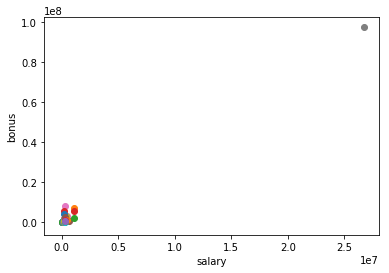

In [20]:

features = ["salary", "bonus"]
#data = poi_id.data
data = featureFormat(data_dict, features)

#data.pop("TOTAL")
def drawplot(data, label_x, label_y):
    for point in data:
        xdis = float(point[0])
        ydis = float(point[1])
        matplotlib.pyplot.scatter(x = xdis, y = ydis)

    matplotlib.pyplot.xlabel(label_x)
    matplotlib.pyplot.ylabel(label_y)
    matplotlib.pyplot.show()
        
        
drawplot(data,"salary", "bonus")

Looking at the fig, there is a outlier. Looking further into the data, the extremely large value is just the total value which has been accounted as a data point. Removing the outlier

### Dataset Without Outliers

There comes out a much cleaner view of the data after removing the outlier.

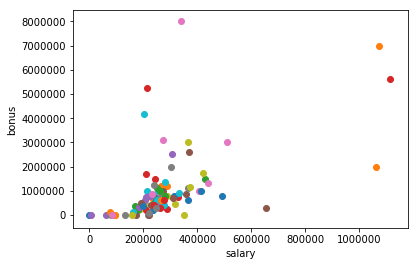

In [21]:
data_dict.pop('TOTAL', 0)
#data_dict.pop('LOCKHART EUGENE E', 0)
data = featureFormat(data_dict, features)
drawplot(data,"salary", "bonus")

### Visualizations for better idea of the concerned features

### Exercised Stock Vs Incentives

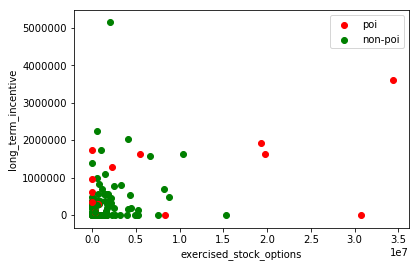

In [22]:
from visuals import DrawPlot
feature_x =  'exercised_stock_options'
feature_y =  'long_term_incentive'
DrawPlot(data_dict, feature_x, feature_y)

### Total Stock vs exercised stock

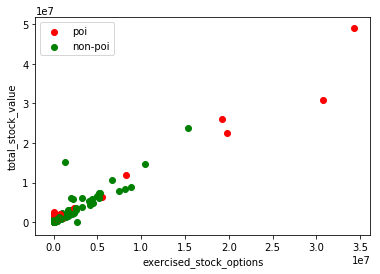

In [23]:
feature_x =  'exercised_stock_options'
feature_y =  'total_stock_value'
DrawPlot(data_dict, feature_x, feature_y)

### Emails sent and Received to PIO

After cleaning the data from outliers I had to pick the most sensible features to use. First I picked 'from_poi_to_this_person' and 'from_this_person_to_poi' but there is was no strong pattern when I plotted the data so I used fractions for both features of “from/to poi messages” and “total from/to messages”.

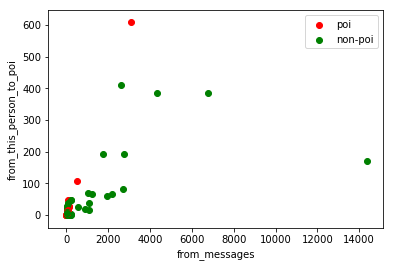

In [24]:
feature_x =  'from_messages'
feature_y =  'from_this_person_to_poi'
DrawPlot(data_dict, feature_x, feature_y)

## Feature Creation and Selection

In our dataset we’ve got the number of emails sent to POI’s and received from POI’s for most of the employees. However, if an employee sends or receives a lot of emails in general, it is likely that the quantity of them sent or received from POI’s would be large as well. This is why we are creating these two new features: - fraction of ‘to_messages’ received from a POI; - fraction of ‘from_messages’ sent to a POI.

They can indicate if the majority of an employee’s emails were exchanged with POI’s. In fact, POI’s are grouped together in a scatter plot of the two new features.

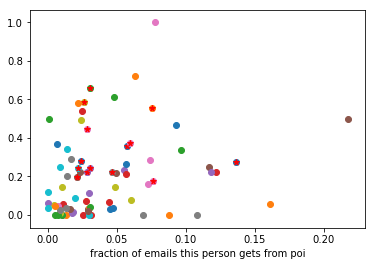

In [25]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    matplotlib.pyplot.scatter( from_poi, to_poi )
    if point[0] == 1:
        matplotlib.pyplot.scatter(from_poi, to_poi, color="r", marker="*")
matplotlib.pyplot.xlabel("fraction of emails this person gets from poi")
matplotlib.pyplot.show()

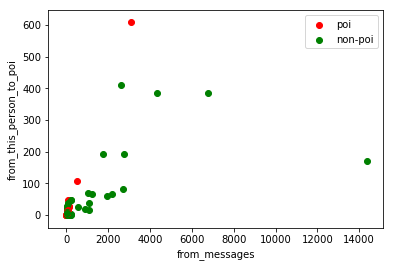

In [26]:
feature_x =  'from_messages'
feature_y =  'from_this_person_to_poi'
DrawPlot(data_dict, feature_x, feature_y)

### Feature Selection
 

Decision Tree Algorithm was also used to rank the features. Selection of features was done by using score value and intutuion.

In [27]:

features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
               'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)


from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"
import numpy as np




pd_data=[]
importances = clf.feature_importances_
print(len(features_list),len(importances) )
import numpy as np
indices = np.argsort(importances)[::-1]

for i in range(14):
    dat = {'id':i,'feature':features_list[i+1],'importance':np.round(importances[indices[i]],3)}
    pd_data.append(dat)
    #print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])
    
    

importances_df = pd.DataFrame(pd_data)
print 'Feature Ranking: '
importances_df



accuracy 0.733333333333
Decision tree algorithm time: 0.0 s
(17, 16)
Feature Ranking: 


,feature,id,importance
0,salary,0,0.200
1,bonus,1,0.195
2,fraction_from_poi_email,2,0.158
3,fraction_to_poi_email,3,0.118
4,deferral_payments,4,0.088
5,total_payments,5,0.075
6,loan_advances,6,0.053
7,restricted_stock_deferred,7,0.053
8,deferred_income,8,0.038
9,total_stock_value,9,0.021


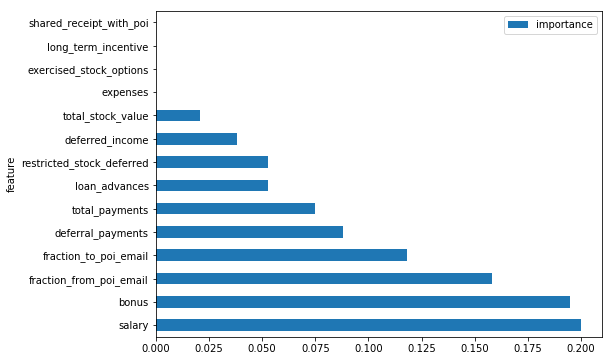

In [28]:

importances_df.plot(x='feature', y='importance', kind='barh', figsize=(8, 6))
matplotlib.pyplot.show()


For the above feature list selected, the accuracy is 0.8, The current set of features gave a precision and recall which were lesser than 0.3. The features were selected dropping one by one which gave a precision value more than 0.3
The final feature list: features: ["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]

### Selection of Algorithm and Tuning

In [20]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

Naive Bayes Algorithm: Accuracy : 0.84
Decision Tree: Accuracy: 0.9(before tuning)
When a model is built for a classification problem, the accuracy of that model is the number of correct predictions from all predictions made. This is the classification accuracy. Classification accuracy alone is typically not enough information to make this decision. The feature set used does not go with the distributional and other assumptions of Naive Bayes. 

In [ ]:
Decision tree Algorithm was selected which gave an accuracy of 0.857 before tuning.
After feature selection and manual tuning of the min_sample_split parameter

In [ ]:
min_sample_split: 2
    
Accuracy: 0.857142857143 Precision: 0.5      Recall: 0.666666666667
            
min_sample_split: 3

Accuracy: 0.892857142857 Precision: 0.5      Recall: 0.666666666667 

min_sample_split: 4
    
Accuracy: 0.89285714285 Precision: 0.5      Recall: 0.666666666667
        
min_sample_split: 5
            
Accuracy: 0.892857142857       Precision: 0.666666666667      Recall: 0.666666666667
            
min_sample_split: 6
    
Accuracy: 0.928571428571       Precision: 0.666666666667      Recall: 0.666666666667
            
min_sample_split: 7
    
Accuracy: 0.928571428571       Precision: 0.666666666667     Recall: 0.666666666667
            
min_sample_split: 8
    
Accuracy: 0.928571428571       Precision: 0.5     Recall: 0.666666666667

### Analysis Validation and Performance

This process was validated using 3-fold cross-validation, precision and recall scores.  Accuracy cannot be used to for evaluvation of the algorithm because the data is imbalanced(very few POI's are present). Therefore the evaluvation is done based on Precision and Recall factors. The best values for min_split parameter during the tuning process is 5 and 6.
I was able to reach the precision and recall values of 0.666, 0.666

### Discussions and Final Conclusion

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
In this case Precision is probability that the person identified as a PIO is actually a PIO. In this case 67% of the time would be true and 33% would raise false alarms about people who are innocent.

Recall measures how likely it is that identifier will flag a POI a recall value of 0.666666666667 means that 67% of the time it would flag a POI and 33% it would not. These values are quite good. There is more room for improvement. The email data that have exchanged will have more data. Digging into the email texts will give more information, Its possible that we can observe  more detailed patterns like specific vocabulory used, specific email addresses used along with other existing features and engineering those features for new ones can provide more deeper details regarding the finding of PIO's. The next step in the development will be to extract more patterns from the emails.  
